# Literature Review and Preliminary Exploratory Data Analysis

## Setup and Imports

To install the conda virtual environment of this project use the following commands.

```
!conda env create -f environment.yml
!conda activate cs109b-grp9-final-project
```

In [1]:
%matplotlib inline

import os
import requests
import tqdm

import zipfile
import lzma
import json

import gzip
import csv

import pandas as pd

from matplotlib import pylab as plt
import seaborn as sns

from itertools import islice
from collections import Counter

import logging
logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.INFO)
logging.root.level = logging.INFO  # ipython sometimes messes up the logging setup; restore
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.similarities import SparseMatrixSimilarity
import numpy as np

from py2neo import Graph

from IPython.display import Image

/Users/bebop/anaconda3/envs/cs109b-grp9-final-project/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


### Data Description


> CAP includes all official, book-published United States case law — every volume designated as an official report of decisions by a court within the United States.
>
>Each volume has been converted into structured, case-level data broken out by majority and dissenting opinion, with >human-checked metadata for party names, docket number, citation, and date.
>
> -- <cite>[Case.law][1]</cite>

In the scope of this analysis we use the latest open case text from from bulk data exxports of open jurisdictions in the dataset. This subset consists of caselaws and metadata for the following four Jurisdictions:

1. ark - Arkansas
2. ill - Illinois
3. nc - North Carolina
4. nm - New Mexico

These were downloaded from [here][2].


**Citation Graph**

In addition to the case text we also use the case citation graph that links extracted, verified and unambiguous  citations to cases within the dataset. We use the citation graph from [2021-04-20][3] for this study. The citation graph is present in the form of a edgelist linking one case_id to multiple case_ids. It also contains all the references to all nodes from the case.law dataset. We truncate the graph based on case_ids we found in the case texts for each jurisdiction during preprocessing.

[1]: https://case.law/about/
[2]: https://case.law/download/bulk_exports/latest/by_jurisdiction/case_text_open/
[3]: https://case.law/download/citation_graph/2021-04-20/


In [2]:
##filename declarations

base_url = "https://case.law/download/bulk_exports/latest/by_jurisdiction/case_text_open/"
base_folder = "../data"
folder_names = ["ark", "ill", "nc", "nm"]
for item in folder_names:
    os.makedirs(f"{base_folder}/{item}", exist_ok=True)

def get_url_loc(file_name, base_url=base_url, base_folder=base_folder):
    url = os.path.join(base_url, file_name)
    file_loc = os.path.join(base_folder, file_name)
    return url, file_loc    
    
    
text_file_names = [f"{item}/{item}_text.zip" for item in folder_names]
xml_file_names = [f"{item}/{item}_xml.zip" for item in folder_names]

text_file_url_locs = list(map(get_url_loc, text_file_names))
xml_file_url_locs = list(map(get_url_loc, xml_file_names))

** downloads **

The following code downloads the raw dataset. 

NB: This is a onetime activity.


```{bash}
# download  citation graph and metadata
!wget -c https://case.law/download/citation_graph/2021-04-20/citations.csv.gz -P ../data/
!wget -c https://case.law/download/citation_graph/2021-04-20/metadata.csv.gz -P ../data/
```


```{python}
for url, file_name in tqdm.tqdm_notebook(text_file_url_locs, total=len(text_file_names)):
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(file_name, "wb") as outfile:
            for chunk in response.iter_content(chunk_size=128):
                outfile.write(chunk)
                
for url, file_name in tqdm.tqdm_notebook(xml_file_url_locs, total=len(xml_file_names)):
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(file_name, "wb") as outfile:
            for chunk in response.iter_content(chunk_size=128):
                outfile.write(chunk)
```

## Data Loading and Clean-up

In [3]:
def load_cases(fnames, field="id"):
    cases = []
    for fname in fnames:
        with zipfile.ZipFile(fname, 'r') as zip_archive:
            xz_path = next(path for path in zip_archive.namelist() if path.endswith('/data.jsonl.xz'))
            with zip_archive.open(xz_path) as xz_archive, lzma.open(xz_archive) as jsonlines:
                for i, line in tqdm.tqdm_notebook(enumerate(jsonlines)):
                    record = json.loads(str(line, 'utf-8'))
                    if field:
                        record = {field: record[field]}
                    cases.append(record)
        print(f"loaded {i+1} cases from {fname.split('/')[-1]}")
    return pd.DataFrame(cases)

def read_citation_graph(fname, case_ids):
    csvobj = csv.reader(gzip.open(fname, mode='rt'),delimiter = ',',quotechar="'")
    graph = []
    for item in tqdm.tqdm_notebook(csvobj):
        head = item[0]
        try:
            head = int(head)
        except ValueError:
            head = None
        if head in case_ids:
            graph.append(item)
    citation_graph = pd.DataFrame(graph)
    citation_graph = citation_graph.set_index(0)
    citation_graph = citation_graph.apply(lambda x: x.dropna().tolist(), axis=1)
    return citation_graph


def read_citiation_metadata(fname, case_ids):
    csvobj = csv.DictReader(gzip.open(fname, mode='rt'),delimiter = ',')
    graph_meta = []
    for item in tqdm.tqdm_notebook(csvobj):
        head = item["id"]
        try:
            head = int(head)
        except ValueError:
            head = None
        if head in case_ids:
            graph_meta.append(item)
    graph_meta = pd.DataFrame(graph_meta).set_index("id")
    return graph_meta

In [4]:
_, text_fnames= zip(*text_file_url_locs)
cases_data = load_cases(text_fnames, field=None)

<ipython-input-3-4b5d67d4d59d>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, line in tqdm.tqdm_notebook(enumerate(jsonlines)):


0it [00:00, ?it/s]

loaded 59735 cases from ark_text.zip


0it [00:00, ?it/s]

loaded 183033 cases from ill_text.zip


0it [00:00, ?it/s]

loaded 97600 cases from nc_text.zip


0it [00:00, ?it/s]

loaded 18338 cases from nm_text.zip


In [5]:
print(f"Total number of cases in the raw dataset : {len(cases_data)}")
print(f"Total number of columns in the raw dataset : {len(cases_data.columns)}")

Total number of cases in the raw dataset : 358706
Total number of columns in the raw dataset : 17


In [6]:
##view the first case
sample_case = cases_data.iloc[0,:].to_json()
#fix for escape chars
sample_case = json.dumps(json.loads(sample_case), indent=2)
print(sample_case)

{
  "id": 1869772,
  "url": "https://api.capapi.org/v1/cases/1869772/",
  "name": "James Joseph STANDLEY, Jr. v. STATE of Arkansas",
  "name_abbreviation": "Standley v. State",
  "decision_date": "1987-11-09",
  "docket_number": "",
  "first_page": "517",
  "last_page": "518",
  "citations": [
    {
      "cite": "293 Ark. 517",
      "type": "official"
    },
    {
      "cite": "738 S.W.2d 423",
      "type": "parallel"
    }
  ],
  "volume": {
    "volume_number": "293",
    "barcode": "32044078577145",
    "url": "https://api.capapi.org/v1/volumes/32044078577145/"
  },
  "reporter": {
    "id": 368,
    "full_name": "Arkansas Reports",
    "url": "https://api.capapi.org/v1/reporters/368/"
  },
  "court": {
    "name_abbreviation": "Ark.",
    "name": "Arkansas Supreme Court",
    "id": 8808,
    "slug": "ark",
    "url": "https://api.capapi.org/v1/courts/ark/"
  },
  "jurisdiction": {
    "name": "Ark.",
    "id": 34,
    "slug": "ark",
    "name_long": "Arkansas",
    "url": "http

**Discussion**

Each caselaw record is represented by a unique id and contains metadata relating to `decision_date`, `volume`, `reporter`, `jurisdiction`, `court` in addition to the case text that comprises of the `head_matter` and `opinions`. We proceed with extracting the and data removing empty values and columns from the dataset before diving into the text and graph processing.

In [9]:
#get columns with any empty values
display(cases_data.applymap(lambda x: True if x else False).all(axis=0))

id                   True
url                  True
name                 True
name_abbreviation    True
decision_date        True
first_page           True
last_page            True
volume               True
reporter             True
court                True
jurisdiction         True
frontend_url         True
casebody             True
dtype: bool

In [13]:
# initally looks like `preview` and `docket_number` are sparse and don't really matter for the problem.
# we'll get the citation information after linking the citation graph
drop_cols = ["docket_number", "preview","cites_to", "citations"]
cases_data = cases_data.drop(drop_cols, axis=1)

In [14]:
# convert the id to int for indexing
cases_data["id"] = cases_data["id"].astype(int)
cases_data = cases_data.set_index("id")

In [15]:
# convert date column
display(cases_data[cases_data.decision_date == "1914-02-29"])
cases_data["decision_date"] = pd.to_datetime(cases_data["decision_date"], format="%Y-%m-%d", errors="coerce")
cases_data = cases_data[cases_data["decision_date"].notnull()]

,url,name,name_abbreviation,decision_date,first_page,last_page,volume,reporter,court,jurisdiction,frontend_url,casebody
id,,,,,,,,,,,,
11269973,https://api.capapi.org/v1/cases/11269973/,STATE v. LESTER MORRIS,State v. Morris,1914-02-29,441,441,"{'volume_number': '166', 'barcode': '320440578...","{'id': 549, 'full_name': 'North Carolina Repor...","{'name_abbreviation': 'N.C.', 'name': 'Supreme...","{'name': 'N.C.', 'id': 5, 'slug': 'nc', 'name_...",https://cite.capapi.org/nc/166/441/,"{'status': 'ok', 'data': {'judges': [], 'head_..."


/Users/bebop/anaconda3/envs/cs109b-grp9-final-project/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


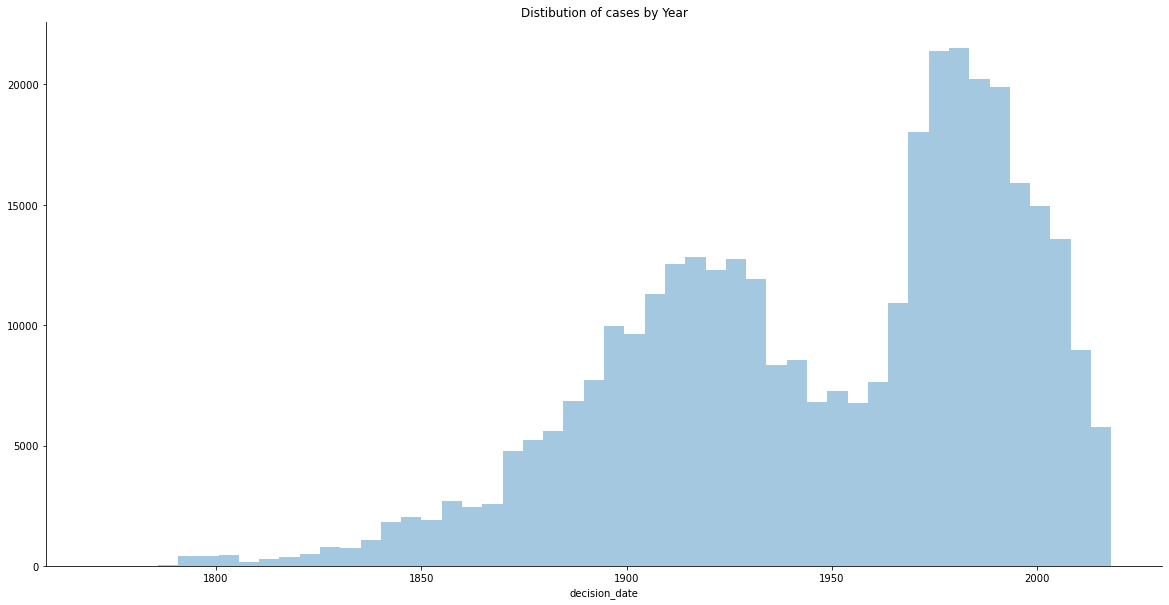

In [16]:
plt.figure(figsize=(20,10))
sns.distplot(pd.DatetimeIndex(cases_data.decision_date).year, kde=False)
plt.title("Distibution of cases by Year")
sns.despine()
plt.show()

In [17]:
## extract and normalize volumes
volumes_data = pd.DataFrame(cases_data.volume.tolist(), index=cases_data.index)
volumes_data.loc[:, "volume_number"] = volumes_data["volume_number"].astype(int)
cases_data.loc[:, "volume_id"] = volumes_data["volume_number"]
volumes_data = volumes_data.drop_duplicates("volume_number")

In [18]:
# volumes_data.to_csv("data/subset/volumes.csv", index=False, index_label=False, quoting=csv.QUOTE_ALL, quotechar='"')

In [19]:
# extract and normalize reporters
reporters_data = pd.DataFrame(cases_data["reporter"].tolist(), index=cases_data.index)
reporters_data.loc[:, "id"] = reporters_data["id"].astype(int)
cases_data.loc[:, "reporter_id"] = reporters_data["id"]
reporters_data = reporters_data.drop_duplicates("id")

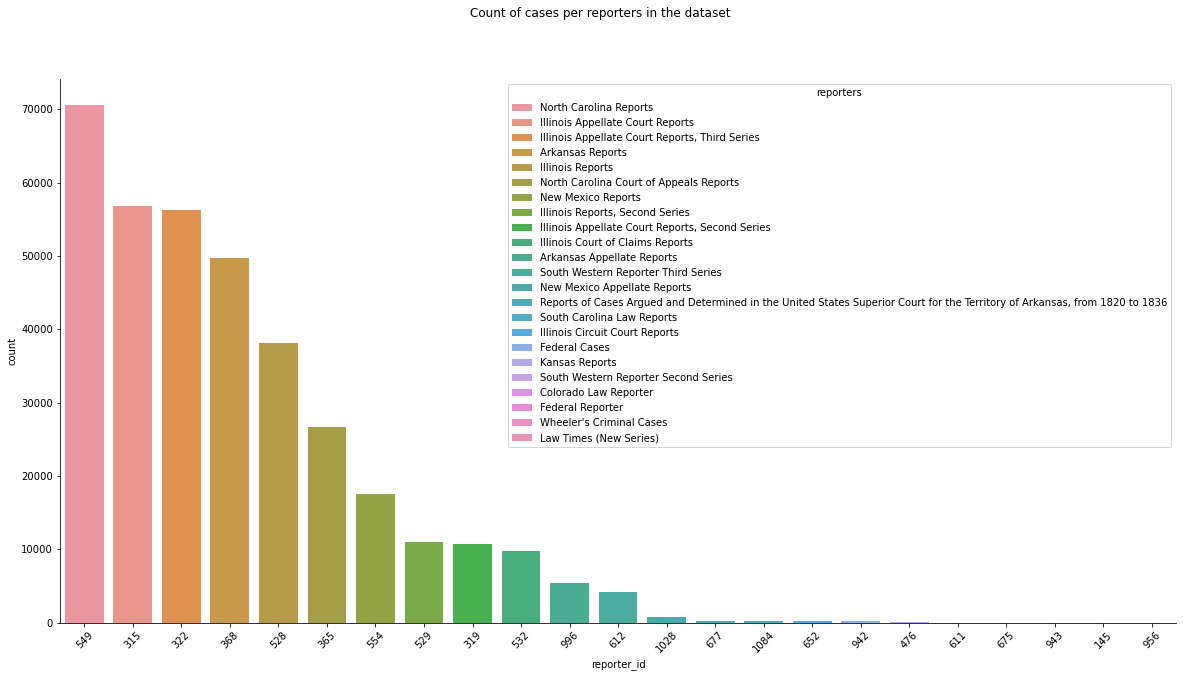

In [20]:
cases_by_reporters = cases_data.reporter_id.value_counts()
reporter_names = reporters_data.set_index("id").loc[cases_by_reporters.index, "full_name"].tolist()
cases_by_reporters = cases_by_reporters.reset_index()
cases_by_reporters['reporters']  = reporter_names
cases_by_reporters = cases_by_reporters.rename({"reporter_id": "count", "index": "reporter_id"}, axis=1)
cases_by_reporters["reporter_id"] = cases_by_reporters["reporter_id"].map(str)
plt.figure(figsize=(20,10))
sns.barplot(data = cases_by_reporters,x="reporter_id", y="count", hue="reporters", dodge=False)
plt.xticks(None, rotation=45)
plt.suptitle("Count of cases per reporters in the dataset")
sns.despine()
plt.show()

**Discussion**

North Carolina has fewest cases when compared to the other jurisdictions in the corpus.
Most of these are however reported by the same reporter.
Hence we observe that `North Carolina Reports` has the most number of cases associated with it in the dataset.

In [21]:
# reporters_data.to_csv("data/subset/reporters.csv", index=False, index_label=False, quoting=csv.QUOTE_ALL, quotechar='"')

In [22]:
# extract and normalize courts
courts_data = pd.DataFrame(cases_data["court"].tolist(), index=cases_data.index)
courts_data.loc[:, "id"] = courts_data["id"].astype(int)
cases_data.loc[:, "court_id"] = courts_data["id"]
courts_data = courts_data.drop_duplicates("id")

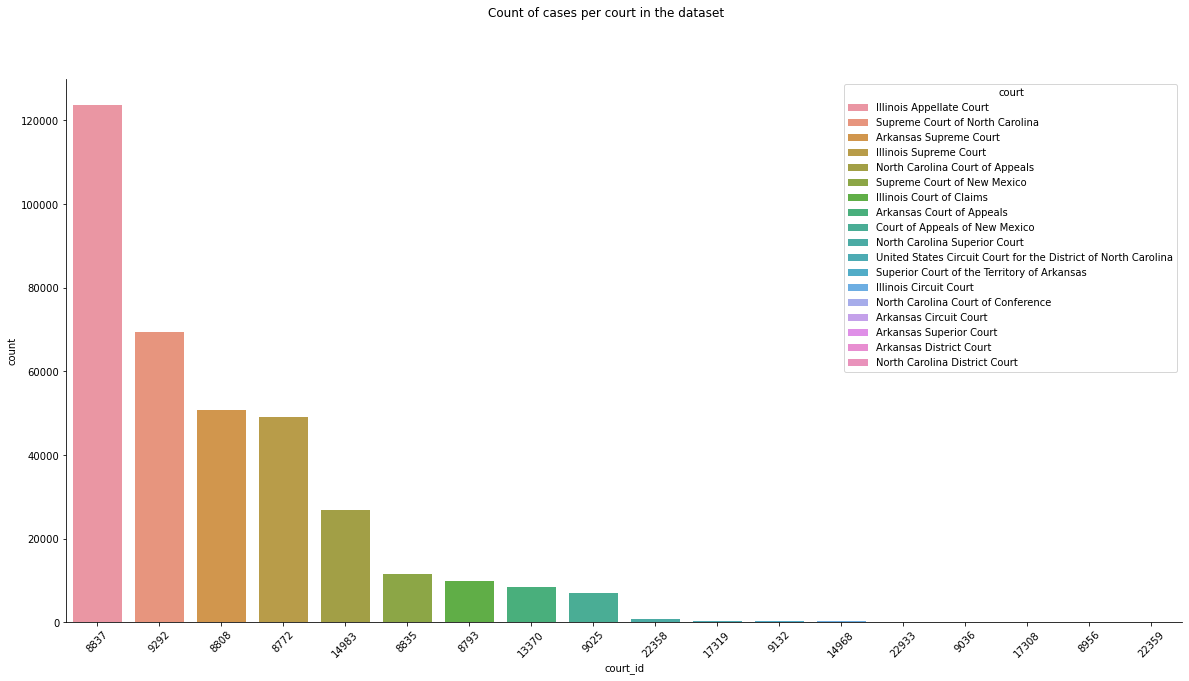

In [23]:
cases_by_courts = cases_data.court_id.value_counts()
court_names = courts_data.set_index("id").loc[cases_by_courts.index, "name"].tolist()

cases_by_courts = cases_by_courts.reset_index()
cases_by_courts['court']  = court_names
cases_by_courts = cases_by_courts.rename({"court_id": "count", "index": "court_id"}, axis=1)
cases_by_courts["court_id"] = cases_by_courts["court_id"].map(str)
plt.figure(figsize=(20,10))
sns.barplot(data = cases_by_courts,x="court_id", y="count", hue="court", dodge=False)


plt.suptitle("Count of cases per court in the dataset")
plt.xticks(rotation=45)
sns.despine()
plt.show()

In [24]:
# courts_data.to_csv("data/subset/courts.csv", index=False, index_label=False, quoting=csv.QUOTE_ALL, quotechar='"')

In [25]:
# extract and normalize jurisdictions
jurisdictions_data = pd.DataFrame(cases_data["jurisdiction"].tolist(), index=cases_data.index)
jurisdictions_data.loc[:,"id"] = jurisdictions_data["id"].astype(int)
cases_data.loc[:, "jurisdiction_id"] = jurisdictions_data["id"]
jurisdictions_data = jurisdictions_data.drop_duplicates("id")

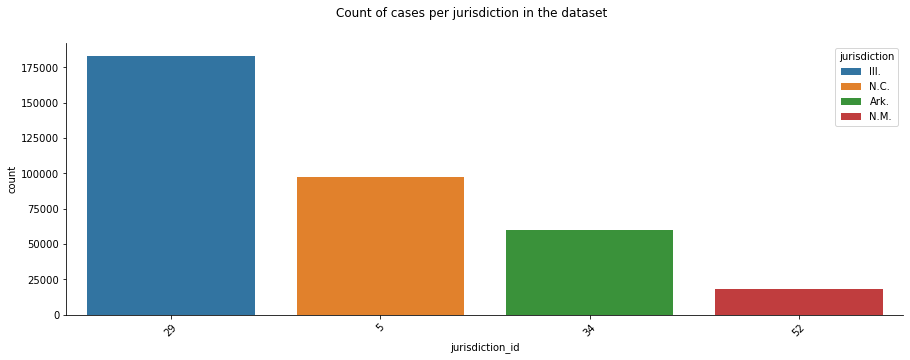

In [26]:
cases_by_jurisdictions = cases_data.jurisdiction_id.value_counts()
jurisdiction_names = jurisdictions_data.set_index("id").loc[cases_by_jurisdictions.index, "name"].tolist()

cases_by_jurisdictions = cases_by_jurisdictions.reset_index()
cases_by_jurisdictions['jurisdiction']  = jurisdiction_names
cases_by_jurisdictions = cases_by_jurisdictions.rename({"jurisdiction_id": "count", "index": "jurisdiction_id"}, axis=1)
cases_by_jurisdictions["jurisdiction_id"] = cases_by_jurisdictions["jurisdiction_id"].map(str)
plt.figure(figsize=(15,5))
sns.barplot(data = cases_by_jurisdictions,x="jurisdiction_id", y="count", hue="jurisdiction", dodge=False)


plt.suptitle("Count of cases per jurisdiction in the dataset")
plt.xticks(rotation=45)
sns.despine()
plt.show()

**Discussion**


- The dataset is skewed with Illinois having more that 175,000 cases while New Mexico has fewer that 25000 cases.

In [27]:
# jurisdictions_data.to_csv("data/subset/jurisdictions.csv", index=False, index_label=False, quoting=csv.QUOTE_ALL, quotechar='"')

In [28]:
# extract case opinion and headmatter
casebody_data = pd.DataFrame(cases_data.loc[:, "casebody"].map(lambda x: x.get("data")).tolist(), index=cases_data.index)
cases_data.loc[: , "head_matter"] = casebody_data.loc[:, "head_matter"]
cases_data.loc[: , "opinion_text"] = casebody_data.loc[:,"opinions"].map(lambda x: "\n".join(y.get("text", "") for y in x))
cases_data["head_matter"] = cases_data["head_matter"]
cases_data["opinion_text"] = cases_data["opinion_text"]

/Users/bebop/anaconda3/envs/cs109b-grp9-final-project/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


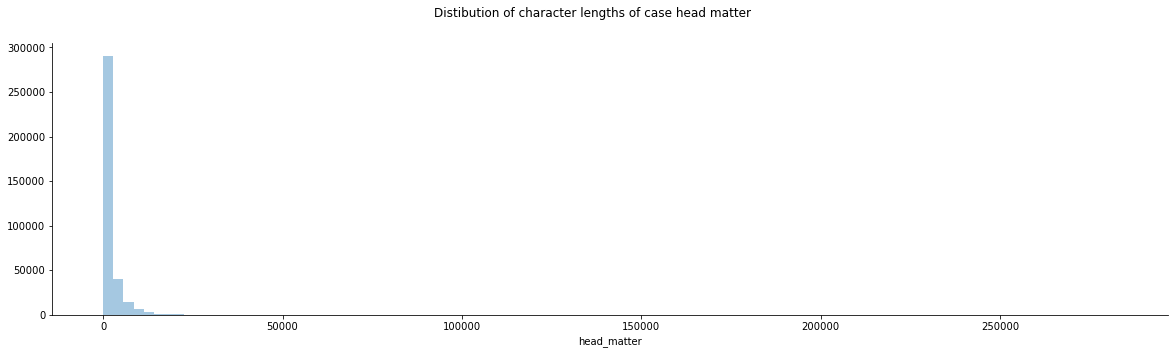

In [29]:
plt.figure(figsize=(20, 5))
sns.distplot(cases_data.head_matter.map(len), bins=100, kde=False)
plt.suptitle("Distibution of character lengths of case head matter")
sns.despine()
plt.show()

In [30]:
display(pd.DataFrame(cases_data.head_matter.map(len).describe()).T)

,count,mean,std,min,25%,50%,75%,max
head_matter,358705.0,1803.8549,3346.039873,0.0,304.0,503.0,2069.0,282840.0


**Discussion**

- Long tail distribution with many texts falling under ~2000 characters

/Users/bebop/anaconda3/envs/cs109b-grp9-final-project/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


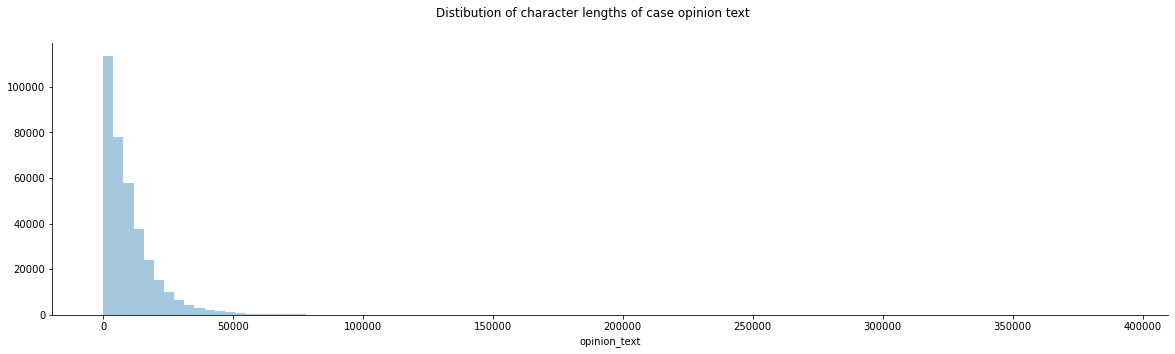

In [31]:
plt.figure(figsize=(20, 5))
sns.distplot(cases_data.opinion_text.map(len), bins=100, kde=False)
plt.suptitle("Distibution of character lengths of case opinion text")
sns.despine()
plt.show()

In [32]:
display(pd.DataFrame(cases_data.opinion_text.map(len).describe()).T)

,count,mean,std,min,25%,50%,75%,max
opinion_text,358705.0,10023.012852,11310.61109,0.0,2732.0,7154.0,13578.0,390445.0


**Discussion**

- Long tail distribution with 75% if texts falling under ~16190 characters

In [33]:
#read citation graph and link nodes
citation_graph = read_citation_graph("../data/citations.csv.gz", case_ids=frozenset(cases_data.index))
print(f"found and loaded {len(citation_graph)} nodes into citation_graph")

#create a lookup for our cases
citations_uids = frozenset(citation_graph.index)

# remove citations that aren't in case data
citation_graph = citation_graph.loc[:].map(lambda x: list(filter(lambda y: y in citations_uids, x)))

# remove cases with no citations after truncation
citation_graph = citation_graph[citation_graph.map(len) > 0]
citation_graph.index = citation_graph.index.astype(int)

cases_data.loc[citation_graph.index, "citation_ids"] = citation_graph.values
cases_data = cases_data[cases_data.citation_ids.notnull()]


<ipython-input-3-4b5d67d4d59d>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for item in tqdm.tqdm_notebook(csvobj):


0it [00:00, ?it/s]

found and loaded 278778 nodes into citation_graph


In [34]:
required_case_cols = [
    'decision_date', 'name', 'name_abbreviation',
    'frontend_url', 'url', 
    #'head_matter', 'opinion_text', 
    'volume_id', 'reporter_id', 'court_id', 'jurisdiction_id',]
#     'citation_ids']
# cases_data[required_case_cols].reset_index().to_csv("data/subset/cases.csv", index=False, index_label=False, quoting=csv.QUOTE_ALL, quotechar='"')


In [35]:
citations_data = cases_data["citation_ids"].explode().reset_index()
citations_data.columns = ["src", "dst"]
# citations_data.to_csv("data/subset/citations.csv", index=False, index_label=False,)


In [36]:
# citations_data = pd.read_csv("../data/subset/citations.csv")

Which cases cite the most number of cases in the dataset?

/Users/bebop/anaconda3/envs/cs109b-grp9-final-project/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


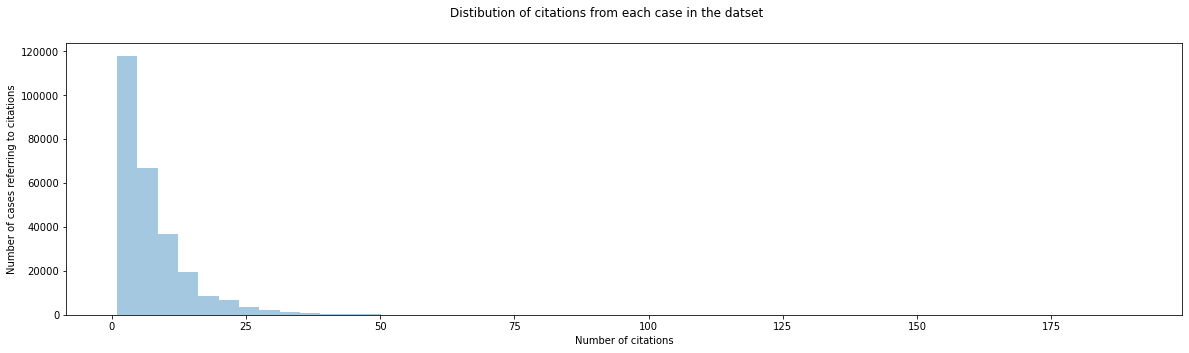

In [37]:
plt.figure(figsize=(20, 5))
sns.distplot(cases_data.citation_ids.map(len), kde=False)
plt.suptitle("Distibution of citations from each case in the datset")
plt.xlabel("Number of citations")
plt.ylabel("Number of cases referring to citations")
plt.show()

In [38]:
display(pd.DataFrame(cases_data.citation_ids.map(len).describe()).T)

,count,mean,std,min,25%,50%,75%,max
citation_ids,265773.0,7.365594,7.31483,1.0,2.0,5.0,10.0,190.0


**Discussion**

We observe that about 75% of the data has 10 or less citations. We also observe some cases citing more than a 100 cases. This needs further investigation.

/Users/bebop/anaconda3/envs/cs109b-grp9-final-project/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


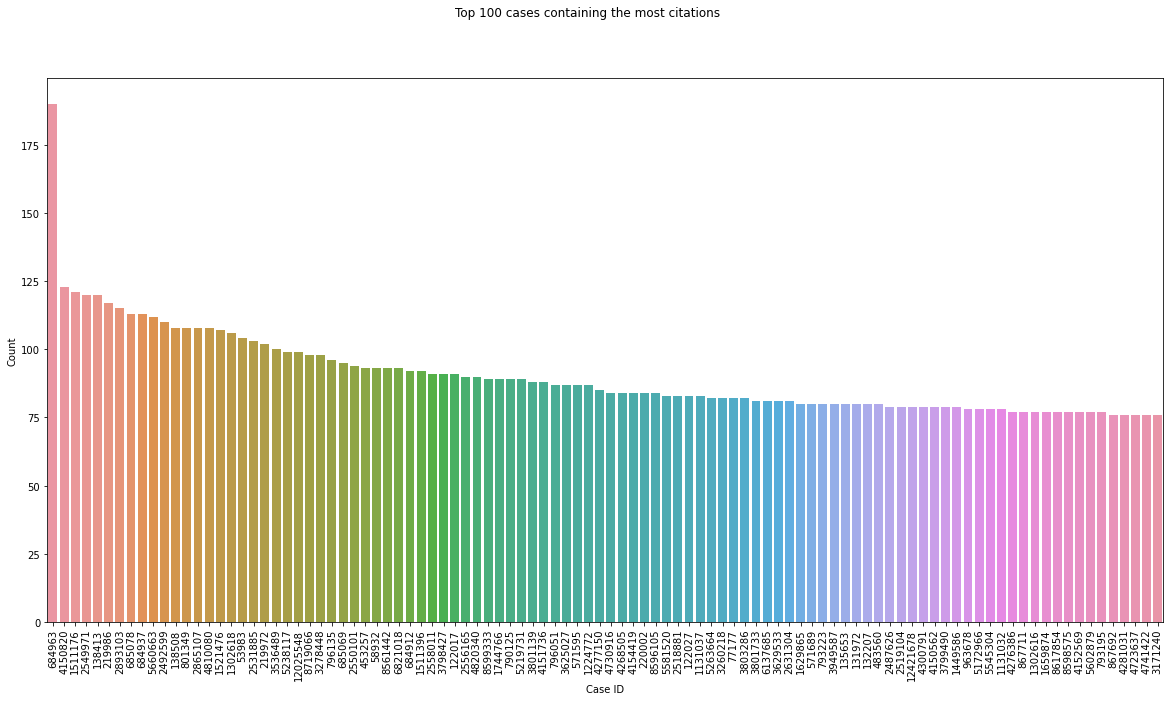

In [39]:
top_cited = citations_data.src.value_counts().head(100)
plt.figure(figsize=(20,10))
ax = sns.barplot(top_cited.index, top_cited.values, order=top_cited.index,)
ax.set(xlabel="Case ID", ylabel = "Count")
plt.xticks(rotation=90)
plt.suptitle("Top 100 cases containing the most citations")
plt.show()

**Discussion**

Some cases cite more than a hundred cases. This might be an anomaly. However, it's equally likely that it is also possible and many cases are referred to in a single caselaw. This naturally supports the idea that caselaws build use citations to build strong arguments.

In [57]:
print(f"Total number of cases in the processed dataset : {len(cases_data)}")
print(f"Total number of columns in the processed dataset : {len(cases_data.columns)}")

Total number of cases in the processed dataset : 265773
Total number of columns in the processed dataset : 19


In [40]:
# casebody_data.loc[cases_data.index].reset_index().to_json("../data/subset/casebody.json", lines=True, orient="records")

## Graph Analysis

We load the graph into [neo4j](https://neo4j.com/) graph database for further analysis. It can be run by running docker and the following command from the project root directory. 

Copy the subset csv files from the `data/subset` folder to the import folder under `neo4j/import/`
Run the following commands.


```{bash}
docker run \
    --name caselaw-neo4j \
    -p7474:7474 -p7687:7687 \
    -d \
    -v $PWD/neo4j/data:/data \
    -v $PWD/neo4j/logs:/logs \
    -v $PWD/neo4j/import:/var/lib/neo4j/import \
    -v $PWD/neo4j/plugins:/plugins \
    -e NEO4J_apoc_export_file_enabled=true \
    -e NEO4J_apoc_import_file_enabled=true \
    -e NEO4J_apoc_import_file_use__neo4j__config=true \
    --env NEO4J_AUTH='neo4j/zaq!0pl' \
    --env NEO4JLABS_PLUGINS='["apoc", "graph-data-science"]' \
    neo4j:latest
```{bash}                            

```{cypher}                            
CREATE CONSTRAINT jurisdictionId IF NOT EXISTS on (jur:Jurisdiction) ASSERT jur.id IS UNIQUE;
LOAD CSV WITH HEADERS FROM 'file:///jurisdictions.csv' AS row
WITH row
MERGE (jurisdiction:Jurisdiction {id:toInteger(row.id)})
ON CREATE SET jurisdiction.name = row.name_long,
jurisdiction.url = row.url;

CREATE CONSTRAINT courtId IF NOT EXISTS on (cou:Court) ASSERT cou.id IS UNIQUE;
LOAD CSV WITH HEADERS FROM 'file:///courts.csv' AS row
WITH row
MERGE (court:Court {id: toInteger(row.id)})
ON CREATE SET court.name = row.name,
court.url = row.url;

CREATE CONSTRAINT reporterId IF NOT EXISTS on (rep:Reporter) ASSERT rep.id IS UNIQUE;
LOAD CSV WITH HEADERS FROM 'file:///reporters.csv' AS row
WITH row
MERGE (reporter:Reporter {id: toInteger(row.id)})
ON CREATE SET reporter.name = row.full_name,
reporter.url = row.url;

CREATE CONSTRAINT volumeId IF NOT EXISTS on (vol:Volume) ASSERT vol.id IS UNIQUE;
LOAD CSV WITH HEADERS FROM 'file:///volumes.csv' AS row
WITH row
MERGE (volume:Volume {id: toInteger(row.volume_number)})
ON CREATE SET volume.barcode = row.barcode,
volume.url = volume.url;

CREATE CONSTRAINT caselawId IF NOT EXISTS on (cas:Caselaw) ASSERT cas.id IS UNIQUE;
:auto USING PERIODIC COMMIT 1000
LOAD CSV WITH HEADERS FROM 'file:///cases.csv' AS row
WITH row
MATCH (volume:Volume {id: toInteger(row.volume_id)})
MATCH (court:Court {id: toInteger(row.court_id)})
MATCH (reporter:Reporter {id: toInteger(row.reporter_id)})
MATCH (jurisdiction:Jurisdiction {id: toInteger(row.jurisdiction_id)})
MERGE (caselaw:Caselaw {id: toInteger(row.id)})
MERGE (caselaw) -[:REPORTED_BY]->(reporter)
MERGE (caselaw) -[:HEARD_BY]->(court)
MERGE (caselaw) -[:IN_VOLUME]->(volume)
MERGE (caselaw) -[:UNDER_JURISIDICTION]->(jurisdiction)
on CREATE SET caselaw.decision_date = datetime(row.decision_date),
caselaw.name = row.name,
caselaw.url = row.url;

:auto USING PERIODIC COMMIT 1000
LOAD CSV WITH HEADERS FROM 'file:///citations.csv' AS row
with row
MATCH (case1: Caselaw {id: toInteger(row.src)})
MATCH (case2: Caselaw {id: toInteger(row.dst)})
MERGE (case1) -[:CITED]-> (case2);

```

For preinstalled database copy the `neo4j` folder from the following drive link https://drive.google.com/drive/folders/1afRp7eMZqIyScYoC1ELdnrKMwfE4YUJh?usp=sharing

In [41]:
#sample case graph visualization

A sample representation of a caselaw in the graph database


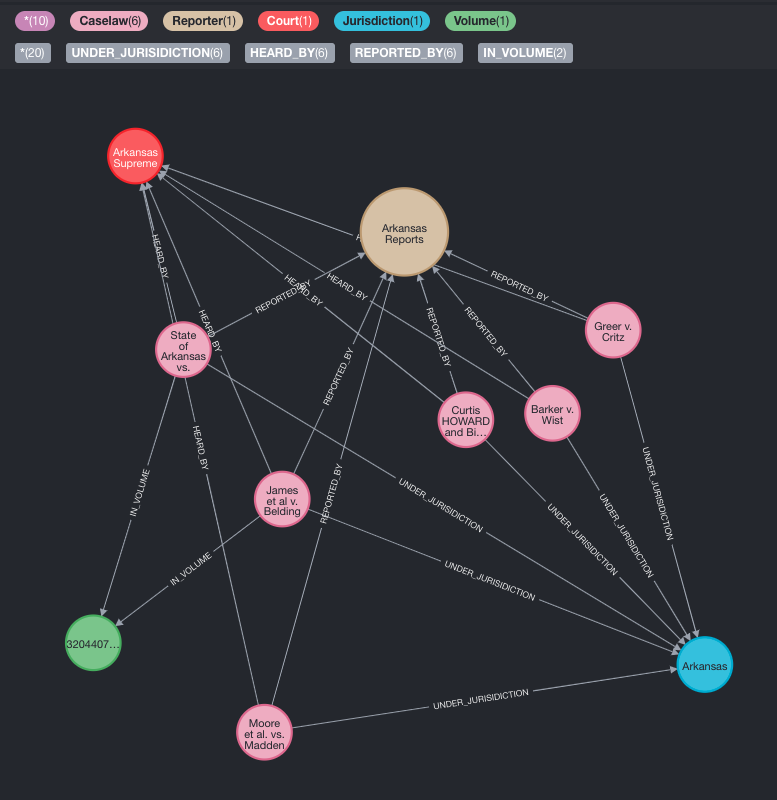

In [42]:

print("A sample representation of a caselaw in the graph database")
Image(filename='../reports/Sample Case law network.png')

In [43]:
graph = Graph(password="zaq!0pl")

In [44]:
# What are the most cited cases in a jurisdiction ?
display(graph.run("""
MATCH g=(j1:Jurisdiction)<-[:UNDER_JURISIDICTION]-(c1:Caselaw)<-[:CITED]-(c2)
with j1, c1, count(DISTINCT c2) as citations
ORDER BY citations desc
WITH j1.name as Jurisdiction, collect(c1.id)[0] as case_id,
collect(c1.name)[0] as case_name, collect(citations)[0] as num_citations
RETURN Jurisdiction, case_id, case_name, num_citations
ORDER BY Jurisdiction ASC
""").to_table())

Jurisdiction,case_id,case_name,num_citations
Arkansas,1709251,Wayne WICKS v. STATE of Arkansas,248
Illinois,2866138,"Raymond Pedrick et al., Appellants, vs. The Peoria and Eastern Railroad Company, Appellee",1639
New Mexico,1588533,"In the Matter of the ADOPTION OF John DOE, and Linda Gayle LEE (Worley), Petitioner-Appellee, v. Rudy Keith LEE, Respondent-Appellant",245
North Carolina,8565416,STATE OF NORTH CAROLINA v. DAVID AMBROSE ODOM a/k/a Dawud Al-Amin Shabazz,598


In [45]:
display(graph.run("""MATCH g=(j1:Jurisdiction)<-[:UNDER_JURISIDICTION]-(c1:Caselaw)<-[:CITED]-(c2)
with j1, c1, count(DISTINCT c2) as citations
ORDER BY citations desc
WITH j1.name as Jurisdiction, collect({caselaw: c1.name, citations: citations}) as top_k
RETURN Jurisdiction, top_k[0..5]
ORDER BY Jurisdiction DESC
""").to_table())

Jurisdiction,top_k[0..5]
North Carolina,"[{caselaw: 'STATE OF NORTH CAROLINA v. DAVID AMBROSE ODOM a/k/a Dawud Al-Amin Shabazz', citations: 598}, {caselaw: 'STATE OF NORTH CAROLINA v. JAMES ALONZO POWELL', citations: 418}, {caselaw: 'STATE OF NORTH CAROLINA v. LARRY DONNELL SMITH', citations: 382}, {caselaw: 'JONAS W. KESSING, Individually; ALICE H. KESSING; JONAS W. KESSING COMPANY; JONAS W. KESSING as General Partner of Village Associates of Chapel Hill Limited Partnership; JONAS W. KESSING as Limited Partner of Village Associates of Chapel Hill Limited Partnership v. NATIONAL MORTGAGE CORPORATION, Individually; NATIONAL MORTGAGE CORPORATION as Limited Partner of Village Associates of Chapel Hill Limited Partnership', citations: 346}, {caselaw: 'CORA VEAZEY v. CITY OF DURHAM', citations: 343}]"
New Mexico,"[{caselaw: 'In the Matter of the ADOPTION OF John DOE, and Linda Gayle LEE (Worley), Petitioner-Appellee, v. Rudy Keith LEE, Respondent-Appellant', citations: 245}, {caselaw: 'Annie GOODMAN et al., Petitioners, v. Nancy S. BROCK, as Administratrix of the Estate of Terry Frank Brock, Deceased, Respondent', citations: 194}, {caselaw: 'STATE of New Mexico, Plaintiff-Respondent, v. Alfredo GOMEZ, Defendant-Petitioner', citations: 186}, {caselaw: 'Roy C. ALEXANDER, Petitioner, v. Yolanda DELGADO, a minor by Jesus Delgado, her father and next friend, and Jesus Delgado, Individually, Respondent', citations: 184}, {caselaw: 'Ron SWAFFORD, Petitioner, v. STATE of New Mexico, Respondent', citations: 174}]"
Illinois,"[{caselaw: 'Raymond Pedrick et al., Appellants, vs. The Peoria and Eastern Railroad Company, Appellee', citations: 1639}, {caselaw: 'THE PEOPLE OF THE STATE OF ILLINOIS, Appellee, v. WILLIE E. ENOCH, Appellant', citations: 1449}, {caselaw: 'THE PEOPLE OF THE STATE OF ILLINOIS, Appellee, v. ROGER COLLINS et al., Appellants', citations: 1173}, {caselaw: 'THE PEOPLE OF THE STATE OF ILLINOIS, Appellant, v. JOSEPH PERRUQUET, Appellee', citations: 1101}, {caselaw: 'THE PEOPLE OF THE STATE OF ILLINOIS, Appellee, v. CHARLES M. ALBANESE, Appellant', citations: 832}]"
Arkansas,"[{caselaw: 'Wayne WICKS v. STATE of Arkansas', citations: 248}, {caselaw: 'Randolph McDONALD v. STATE of Arkansas', citations: 167}, {caselaw: 'Roy Lee DIXON v. STATE of Arkansas', citations: 149}, {caselaw: 'Tiffany Amelia DINKINS v. ARKANSAS DEPARTMENT of HUMAN SERVICES', citations: 137}, {caselaw: 'Alford v. State', citations: 125}]"


In [46]:
display(graph.run("""MATCH (j1:Jurisdiction)<-[:UNDER_JURISIDICTION]-(c1:Caselaw)-[:CITED]-(c2:Caselaw)-[:UNDER_JURISIDICTION]->(j2:Jurisdiction)
WHERE j1 <> j2
WITH j1, j2, count(DISTINCT c2) as cids
ORDER BY cids DESC
RETURN j1.name as src_Jurisdiction, collect(j2.name)[0] as dest_Jurisdiction, cids as cited_cases;""").to_table())

src_Jurisdiction,dest_Jurisdiction,cited_cases
North Carolina,Illinois,2770
Arkansas,Illinois,2719
New Mexico,Illinois,2645
Illinois,North Carolina,2438
Illinois,Arkansas,2333
Illinois,New Mexico,2018
Arkansas,North Carolina,1426
North Carolina,Arkansas,1413
New Mexico,Arkansas,1221
New Mexico,North Carolina,1065


*How are cases from one jurisdiction related to another ?*

The following query shows a sample of cases that connect different jurisdictions in the graph.

```{cypher}
MATCH (co1:Court)<-[:HEARD_BY]-(c1:Caselaw)-[:CITED]-(c2:Caselaw)-[:HEARD_BY]->(co2:Court),
(c1)-[:UNDER_JURISIDICTION]->(j1:Jurisdiction)
WHERE not((c2)-[:UNDER_JURISIDICTION]->(j1))
RETURN co1, co2, c1, c2, j1
LIMIT 20;
```

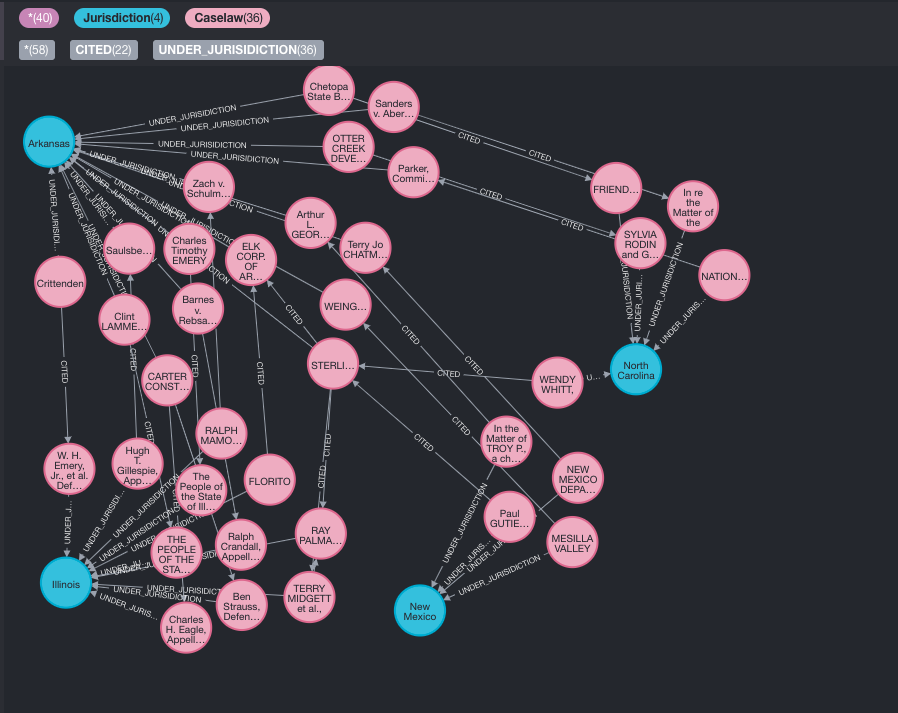

In [47]:
Image(filename='../reports/Cases relating one jurisdiction to another.png')

How about cases citing from courts in other jurisdictions ?

The following query allows us to retrive a sample of cases that linked to courts in Arkansas and courts from other Jurisdictions.

```
MATCH (j1:Jurisdiction)<-[:UNDER_JURISIDICTION]-(c1:Caselaw)-[:CITED]-(c2:Caselaw)-[:UNDER_JURISIDICTION]->(j2:Jurisdiction)
WHERE j1 <> j2
RETURN j2,c1, c2, j1
LIMIT 20;
```

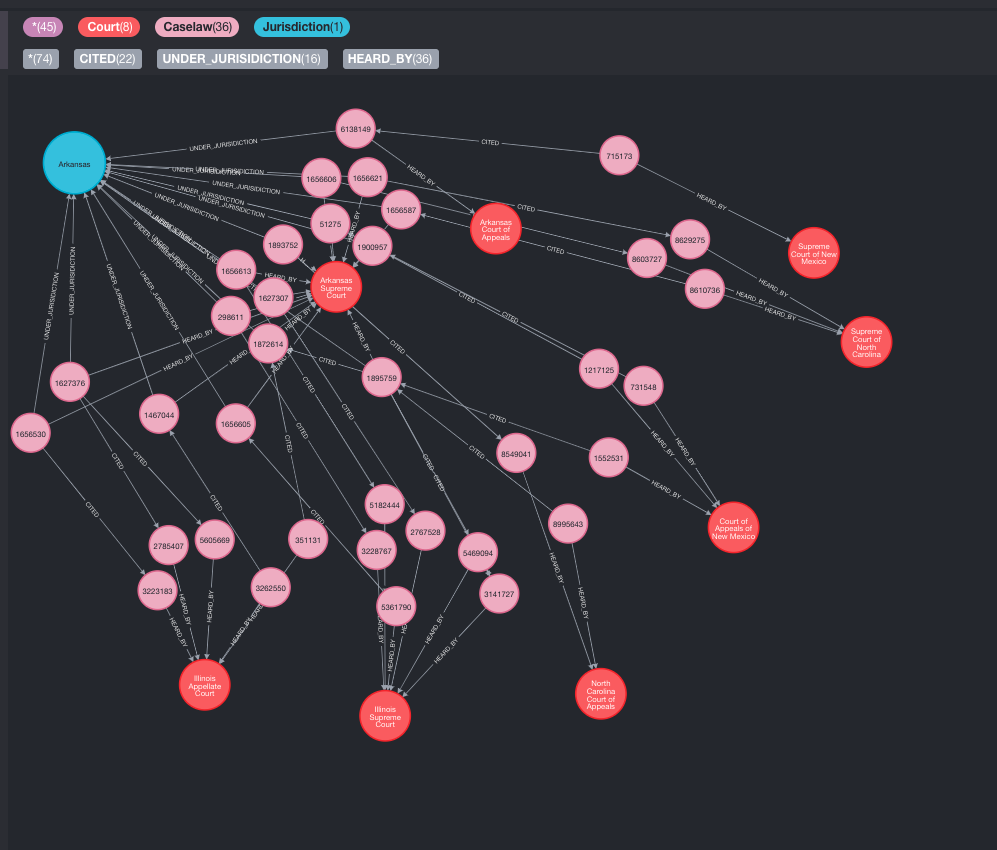

In [48]:
Image(filename='../reports/sample_jurisdiction court_graph.png')

## Text Data Analysis

**Preprocessing**

As we saw the case texts are quite large approx. (28k-50k characters). The texts also contaim misspellings and OCR errors. Additionally, we see hints from reviewing a few sample cases that there are mentions of person names, organizations and other entities such as dates in the case data that might be relevant in idenifying the facts of a case. To preprocess the text, we first concatenate the case text (`Head matter` and `Opinions`) into a single field and proceed to preprocess the text.

**Preprocessing Steps**
 - We parse the text applying POS tagging to the text using [spacy](https://spacy.io/).
 - We retain only words that are tagged as `Adjectives`, `Adverbs`, `Nouns`, `Proper Nouns` and `Pronouns`.
 - This reduces the vocabulary size and reduces the dimensionality of the data by a large factor and makes it feasable to work with the text in the dataset for our Exploratory analysis.

```{python}
###
### CAUTION TAKE REALLY LONG TIME TO RUN

!python -m spacy download en_core_web_sm

import spacy

nlp = spacy.load("en_core_web_sm")
casetext = casebody_data["head_matter"] + "\n"+ casebody_data["opinions"].map(lambda x: " ".join(y.get("text", "") for y in x))
with open("../data/subset/caselines.txt", "w+") as outfile:
    tags = frozenset(["ADJ","ADV","NOUN","PRON","PROPN"])
    for doc in tqdm.tqdm_notebook(nlp.pipe(casetext,batch_size=10, n_process=-1), total=len(casetext)):
        tokens = []
        for tok in doc:
            if tok.pos_ in tags and tok.is_alpha:
                tokens.append(tok.lemma_.lower())
        tokens = " ".join(tokens)
        tokens = preprocess_string(tokens,DEFAULT_FILTERS[:-1])
        outline = " ".join(tokens) + "\n"
        outfile.write(outline)
```

In [49]:
case_lines = pd.read_csv("../data/subset/caselines.txt", header=None, names=["text"])
case_lines.index=cases_data.index

In [50]:
# cases_data = cases_data[["head_matter", "jurisdiction_id", "court_id", "name_abbreviation", "citation_ids"]]
cases_data["citation_ids"] = cases_data.citation_ids.map(lambda x: [int(y) for y in x])

In [51]:
from pandas import option_context
# sample preprocessed text
with option_context('display.max_colwidth', 400):
    display(case_lines.head())


,text
id,
1879972,curtis howard billy howard state arkansas supreme court arkansas opinion september james simpson appellant curtis howard cynthia fearno appellant billy howard steve clark velda west vanderbilt asst appellee george rose smith justice appellant curtis billy howard brother aggravated robbery theft property curtis habitual offender consecutive term life year billy concurrent term year separate bri...
1360455,empire rice company stone opinion november principal agent dealing general agent person general agent apparent scope authority notice limitation thereon specific instruction method eonductng business principal sale unauthorized act agent defendant rice general agent fact defendant agent purchase price plaintiff purchase ratification defendant agent act rice account appeal poinsett circuit cour...
1360511,autrey state opinion november criminal law instruction place punishment minor prosecution year old boy jail delivery attorney defendant reform school court defendant objection ruling tantamount instruction effect prejudicial liability person guilty implement escape county prisoner liable crawford moses dig appeal sevier circuit court james steel judge statement pact indictment case loyd autrey...
1360553,shaw state opinion september false pretense sufficiency evidence proof prosecution personal property false pretense witness defendant certain claim property defendant occasionally arrest sufficient charge defendant threat arrest accusation officer appeal hot spring circuit court evans judge cobh appellant utley attorney general elbert godwin hammock assistants appellee hart gid shaw appeal jud...
1360493,mitchell state opinion october indictment information statutory offense indictment statute certainty defendant act circumstance intent statute prostitution indictment statute crawford moses dig female state purpose prostitution bad qualifying word statute promise threat word inveigle entice criminal law error jury trial woman uuder crawford moses dig female year old felony state farm women cou...


In [52]:
def flatten(lst):
    return (item for sublist in lst for item in sublist)

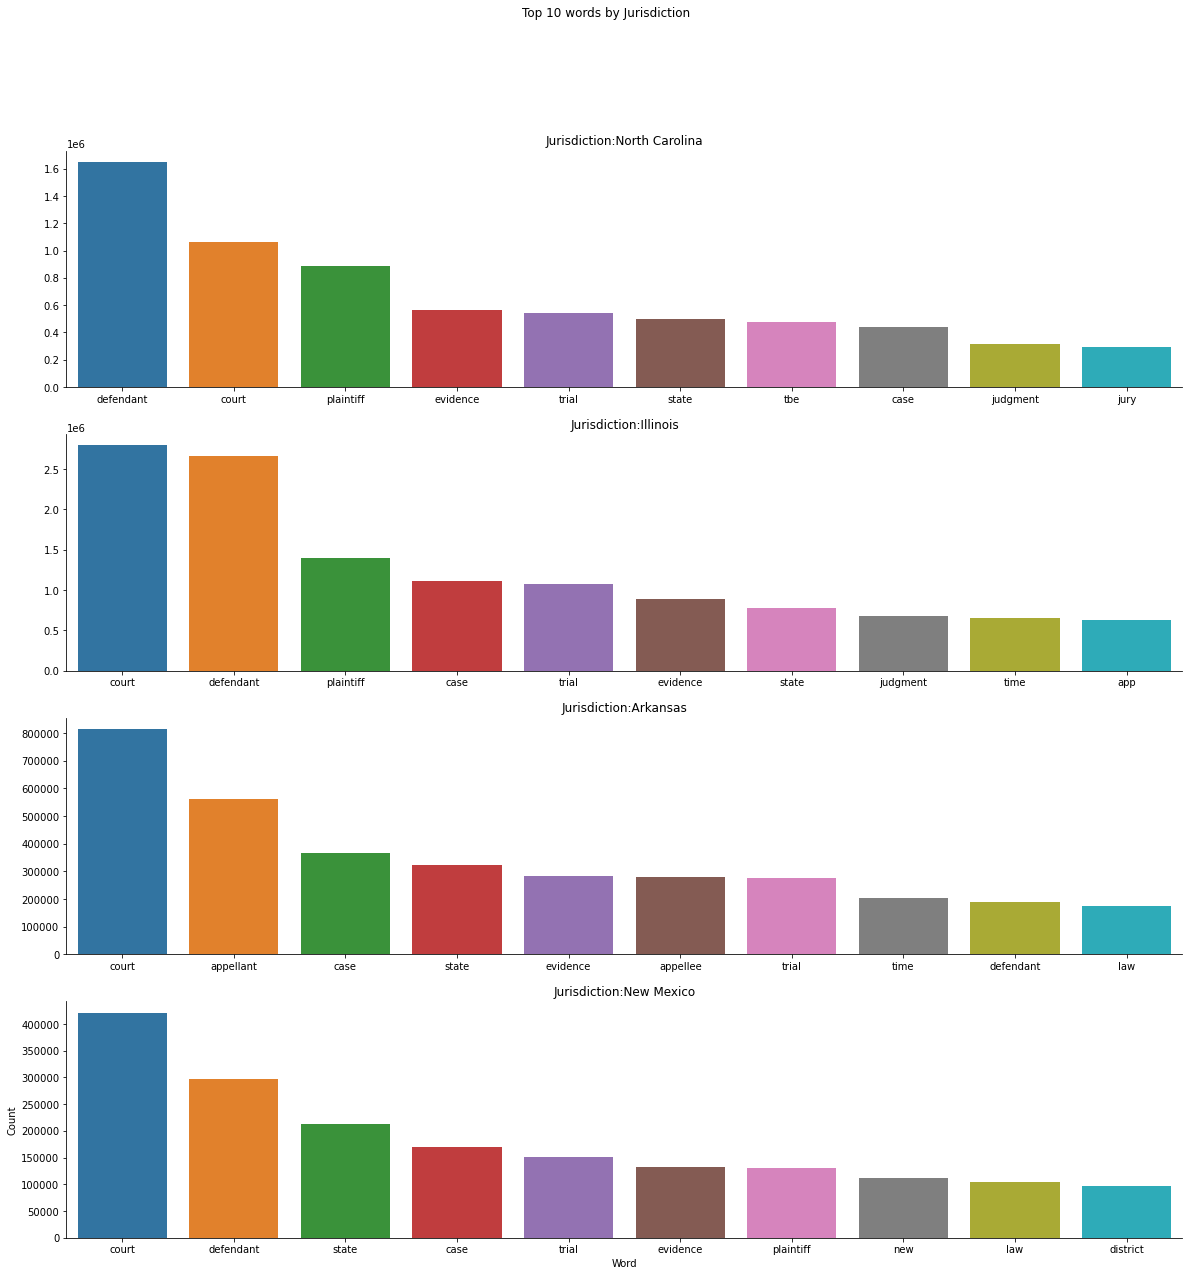

In [53]:
grp_vocab = {}
groups = cases_data.groupby("jurisdiction_id").groups.items()
for grp,idx in groups:
    grp_data = case_lines.loc[idx]
    top_10 = Counter(flatten(grp_data.text.str.split().tolist())).most_common(10)
    grp_vocab[grp] = top_10
num_plots = len(grp_vocab)
fig, ax = plt.subplots(nrows=num_plots, ncols=1, figsize=(20, 20))
for i, (k,v) in enumerate(grp_vocab.items()):
    title = jurisdictions_data[jurisdictions_data.id == k]['name_long'].values[0]
    word, count = zip(*v)
    sns.barplot(x=np.array(word),y=np.array(count),ax=ax[i])
    ax[i].set_title(f"Jurisdiction:{title}")
plt.xlabel("Word")
plt.ylabel("Count")
plt.suptitle("Top 10 words by Jurisdiction")
sns.despine()
plt.show()

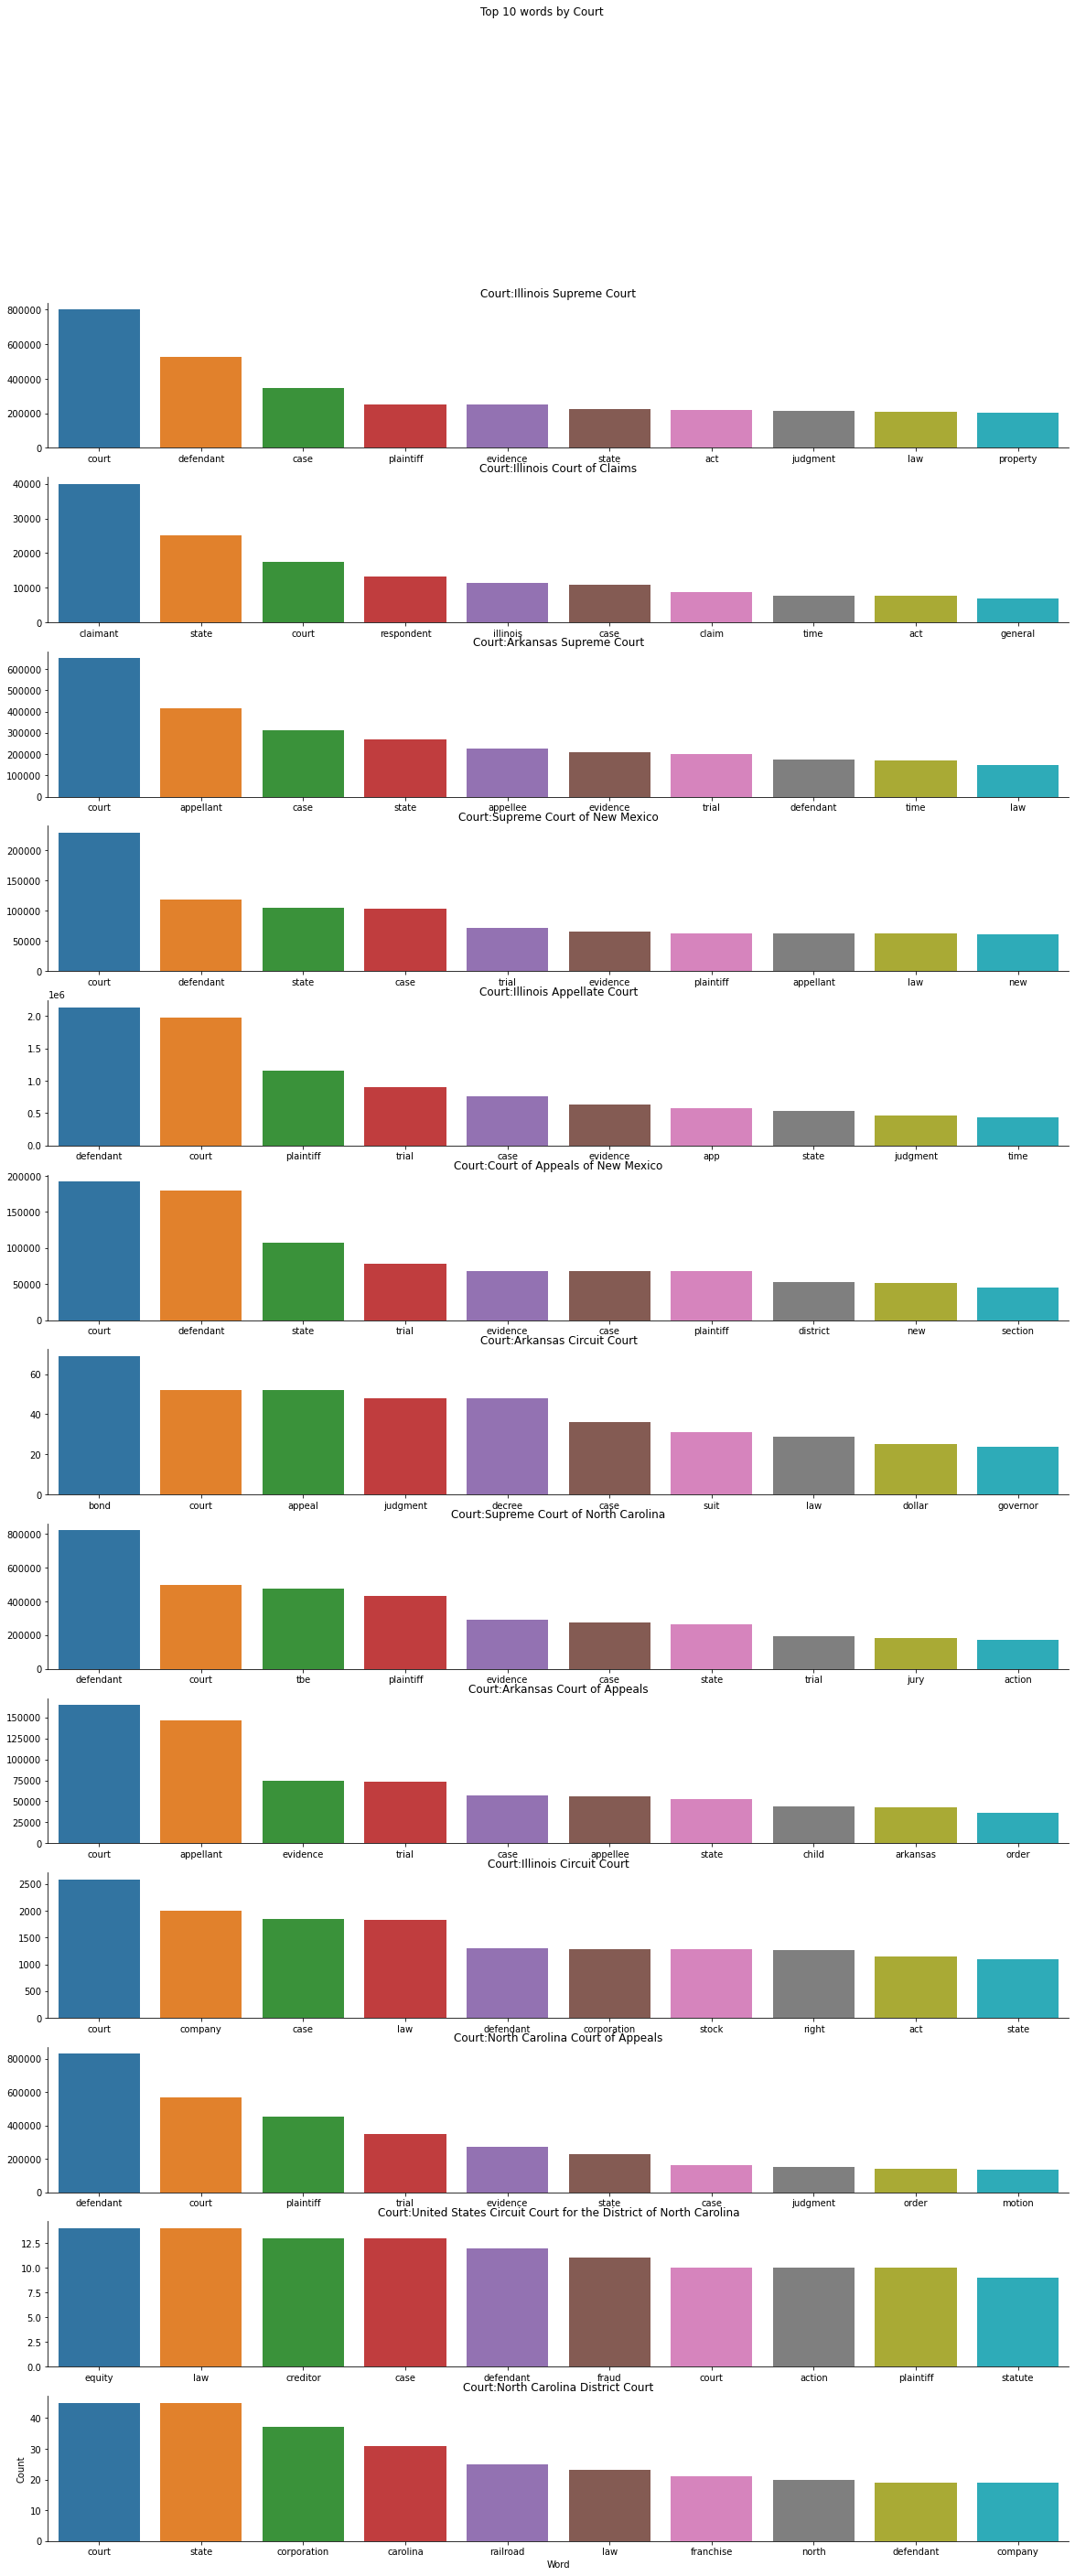

In [54]:
grp_vocab = {}
groups = cases_data.groupby("court_id").groups.items()
for grp,idx in groups:
    grp_data = case_lines.loc[idx]
    top_10 = Counter(flatten(grp_data.text.str.split().tolist())).most_common(10)
    grp_vocab[grp] = top_10
num_plots = len(grp_vocab)
fig, ax = plt.subplots(nrows=num_plots, ncols=1, figsize=(20, 40))
for i, (k,v) in enumerate(grp_vocab.items()):
    title = courts_data[courts_data.id == k]['name'].values[0]
    word, count = zip(*v)
    sns.barplot(x=np.array(word),y=np.array(count),ax=ax[i])
    ax[i].set_title(f"Court:{title}")
plt.xlabel("Word")
plt.ylabel("Count")
plt.suptitle("Top 10 words by Court")
sns.despine()
plt.show()

**Discussion**
- Most of the top words are the same among the Jurisdictions and include: 
- We observe a small variation among the top words in the Courts For instance `court of appeals`  and `appallette courts` frequently feature the terms such as `defendent` and `appellent`.

## Baseline

**A Simple Baseline: Text Similarity for recommending citations.**

We hypothesize that cited caselaws often share similar vocabulary with the citing case text. This motivate us to explore a similarity metrics such since cosine similarity among document vectors to retrieve relevant documents given a query document.

**Methodology**

- We convert the preprocessed text to a bag-of-words representation. 
- The vocabulary contains ~538954 words. 
- We reduce the dimensionality of the data by pruning the vocabulary to retain the 50000 most common words. 
- Next we create TFIDF vectors of the documents and measure the cosine similarity of the tfidf vectors.
- We then compute the mean cosine similarity of a sample of documents in the corpus with their citations to answer the question- `How similar are cited cases to each other ?`

In [59]:
# class CaselineIterator:
#     def __init__(self, fname, slice_size=None):
#         self.fname = fname
#         self.slice_size=slice_size
#         self._length = slice_size
#     def __iter__(self):
#         if self.slice_size:
#             iterator = islice(open(self.fname), self.slice_size)
#         else:
#             iterator = open(self.fname)
#         for line in iterator:
#             yield line.split()
            
#     def __len__(self):
#         if not self._length:
#             self._length = sum(1 for _ in open(self.fname))
#         return self._length

class CaselawCorpus():
    def __init__(self, iterator, dictionary, **kwargs):
        self.iterator = iterator
        self.dictionary = dictionary
        
    def __iter__(self):
        for line in self.iterator:
            # assume there's one document per line, tokens separated by whitespace
            yield self.dictionary.doc2bow(line)
    def __len__(self):
        return len(self.iterator)

In [60]:
class CosineSimilariyIndexer:
    def __init__(self, no_below=5, no_above=0.75):
        self.dictionary = None
        self.corpus = None
        self.model = None
        self.index = None
        self.no_below=no_below
        self.no_above=no_above
    
    def fit(self, texts, **kwargs):
        self.dictionary = Dictionary(texts)
        self.dictionary.filter_extremes(self.no_below, self.no_above, keep_n=50000)
        self.dictionary.compactify()
        
        self.corpus = CaselawCorpus(texts, self.dictionary,**kwargs)
        self.model = TfidfModel(self.corpus)
        self.index = SparseMatrixSimilarity(
            self.model[self.corpus], 
            num_features=len(self.dictionary),
            num_terms=len(self.dictionary),
            num_docs=len(self.corpus),
            maintain_sparsity=True)
        return self
    
    def predict(self, texts, top_k=5):
        pred_corpus = CaselawCorpus(texts, self.dictionary)
        pred_vecs = self.model[pred_corpus]
        pred_sims = self.index[pred_vecs]
        return pred_sims

In [61]:
similarity_indexer = CosineSimilariyIndexer()

In [62]:
del cases_data, case_lines, casebody_data, citation_graph, citations_data

In [63]:
cases_data = pd.read_json("../data/subset/case_info.json", lines=True, orient="records")
case_lines = pd.read_csv("../data/subset/caselines.txt", header=None, names=["text"])
case_lines.index=cases_data.index

In [64]:
id2cases = pd.Series(cases_data.index, index=pd.Index(cases_data["id"]))

In [65]:
#create a lookup for our cases
citations_uids = frozenset(cases_data["id"])

# remove citations that aren't in case data
cases_data["citation_ids"] = cases_data.citation_ids.map(lambda x: list(filter(lambda y: y in citations_uids, x)))
cases_data["citation_idxs"] = cases_data.citation_ids.map(lambda x: id2cases[x].tolist())

In [67]:
similarity_indexer.fit(case_lines.text.str.split())

INFO : adding document #0 to Dictionary(0 unique tokens: [])
INFO : adding document #10000 to Dictionary(64968 unique tokens: ['abundance', 'admissible', 'affirmed', 'afraid', 'afternoon']...)
INFO : adding document #20000 to Dictionary(106292 unique tokens: ['abundance', 'admissible', 'affirmed', 'afraid', 'afternoon']...)
INFO : adding document #30000 to Dictionary(126087 unique tokens: ['abundance', 'admissible', 'affirmed', 'afraid', 'afternoon']...)
INFO : adding document #40000 to Dictionary(153308 unique tokens: ['abundance', 'admissible', 'affirmed', 'afraid', 'afternoon']...)
INFO : adding document #50000 to Dictionary(171385 unique tokens: ['abundance', 'admissible', 'affirmed', 'afraid', 'afternoon']...)
INFO : adding document #60000 to Dictionary(209160 unique tokens: ['abundance', 'admissible', 'affirmed', 'afraid', 'afternoon']...)
INFO : adding document #70000 to Dictionary(232570 unique tokens: ['abundance', 'admissible', 'affirmed', 'afraid', 'afternoon']...)
INFO : ad

In [69]:
# we sample a few cases to validate our hypothesis related to text similarity
# note this is still training set and not a dev or test set
sample_case_lines = case_lines.sample(1000)
with pd.option_context('display.max_colwidth', 400):
    display(sample_case_lines.head())

,text
227356,state george dalton april criminal law right credibility defendant testimony defendant criminal action behalf credibility testimony subject impeachment competent state cross examination warrant federal court credibility witness appeal defendant shaw jury fall term stoices error indictment defendant manufacture intoxicating liquor liquor possession liquor possession purpose sale jury verdict gu...
96954,junior ostendorf appellees international harvester company international harvester company appellant opinion february denial march thomas mamer haughey champaign lord bissell brook chicago william brinkman richard mculler hugh griffin counsel appellant cook shevlin keefe east louis bruce cook thomas keefe counsel appellee justice clark opinion court junior ostendorf october international harve...
197847,gregory poole equipment howard coble secretary revenue state north carolina march taxation sale equipment trade local sale tax retailer business county local government sale tax tax county tangible personal property previously trade payment sale price new property county kind transaction state sale tax exemption local sale tax sale price new article county appeal pursuant decision court appeal...
80597,people state illinois appellant george pasfield exr appellee opinion june rehearing october inheritance tax expense administration tax debt claim decedent estate expense administration gross value estate state inheritance tax expense executor successfully suit expense administration federal estate tax state tax federal estate tax act federal tax charge expense estate decedent share legatee dis...
262946,armendaris water development company plaintiff appellee ralph rainwater enterprises defendants appellant miller associates defendant court appeals new mexico ruth schifani modrall sperling roehl harris sisk albuquerque plaintiff appellee anthony avallone law systems las cruces las cruces defendant appellant opinion minzner judge appellant ralph rainwater enterprises decision district court lie...


In [70]:
# get similairty of queries to corpus
sample_preds = similarity_indexer.predict(sample_case_lines.text.str.split())

In [71]:
# convert predictions into dense matrix
sample_preds = sample_preds.toarray()

In [72]:
# compute the mean similarities of citations and their corresponding documents
all_sims = []
for item in tqdm.tqdm_notebook(cases_data.loc[sample_case_lines.index].citation_idxs):
    for idx, sim in zip(item, sample_preds):
        
        mean_sim = sim[idx].mean()
        all_sims.append(mean_sim)


<ipython-input-72-4713b8705221>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for item in tqdm.tqdm_notebook(cases_data.loc[sample_case_lines.index].citation_idxs):


  0%|          | 0/1000 [00:00<?, ?it/s]

In [73]:
print(f"Mean cosine similarity of a sample of 1000 cases to their citations: {np.mean(all_sims):2.5f}")

Mean cosine similarity of a sample of 1000 cases to their citations: 0.02203


**Discussion**
 - Very low mean similarities among cited documents
 - This is perhaps due to the high dimensionality of data.
 - TFIDF doesn't capture other factors such as jurisdiction, court and date in similarity calculation.

**A simple heuristic to improve our baseline**

Since we know that cases are more often cited among Jurisdictions and courts we use this to arrive at a baseline when used alongside our cosine similarity index. We take the following approach during inference in out baseline:

While predicting the recommendations include only documents from the corpus that have:
    - the same jurisdiction_id
    - the same court_id and
    - has a data before the query document date.
    
These assumptions are valid even for documents that are quried for citations recommendations. i.e. even for unknown documents we know what `court` and `jurisdiction` a case if being decided at when referring to a caselaw.

In [74]:
top_k = 10
top_preds= []
for (idx, row), sample_pred in tqdm.tqdm_notebook(zip(cases_data.loc[sample_case_lines.index].iterrows(), sample_preds)):
    row = row.to_dict()
    
    jur_id = row["jurisdiction_id"]
    court_id = row["court_id"]
    decision_date = row["decision_date"]
    sample_pred = sample_pred.argsort()[::-1]
    pred = sample_pred[
        (cases_data.jurisdiction_id == jur_id) &\
        (cases_data.court_id == court_id) &\
        (cases_data.decision_date > decision_date)]
    top_preds.append(pred)
    

<ipython-input-74-b588b3cfaa88>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for (idx, row), sample_pred in tqdm.tqdm_notebook(zip(cases_data.loc[sample_case_lines.index].iterrows(), sample_preds)):


0it [00:00, ?it/s]

In [75]:
def precision_recall_k(y_true, y_pred, k=10):
    precisions =[]
    recalls = []
    for y_t, y_p in zip(y_true, y_pred):
        y_p = y_p[:k]
        relevant_retrieved = set(y_t).intersection(y_p)
        if relevant_retrieved:
            precision = len(relevant_retrieved)/len(y_p)
            recall = len(relevant_retrieved)/len(y_t)
            precisions.append(precision)
            recalls.append(recall)
    return np.mean(precisions), np.mean(recalls)

In [76]:
precisions =[]
recalls = []
for i in range(3,30, 3):
    precision, recall =  precision_recall_k(cases_data.loc[sample_case_lines.index].citation_idxs.values, top_preds, i)
    precisions.append(precision)
    recalls.append(recall)

In [77]:
pk_plot_df = pd.DataFrame(zip(precisions, recalls), columns=["precision", "recall"], index=range(3,30,3))

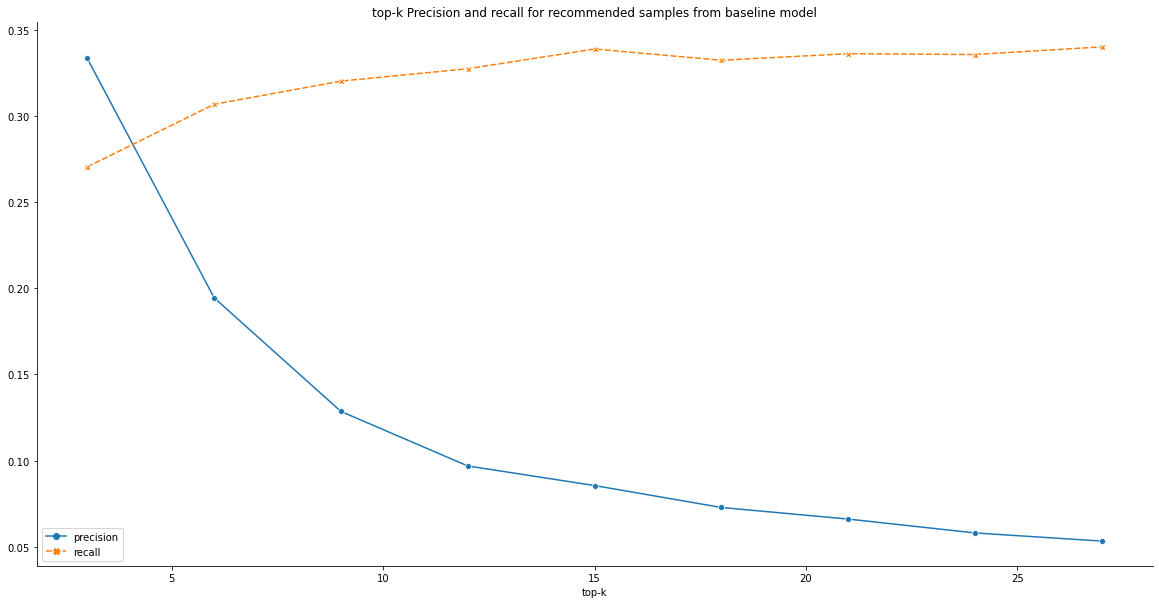

In [78]:
plt.figure(figsize=(20,10))
sns.lineplot(data=pk_plot_df, markers=True)
plt.title("top-k Precision and recall for recommended samples from baseline model")
plt.xlabel("top-k")
sns.despine()
plt.show()

**Discussion**

- Not much gain in recall even as we increase the number of retrieved documents.
- Precision drops very steeply after 5 documents.
- Top-5 results seem to have the best precision and recall.

### Questions and Next steps 

- How do we build a train and test set when we need know they overlap in terms of cited and citing documents ?
- It looks like a simple information retereival approch is not enough when building caselaw recommendation systems.
- How do we represent the global and local context of a citation when making a recommendations ?
- Can we exploit the graph structure to derive secondary references of citations to allow for deeper research in recommendations ?
- Explore building graph based embeddings that can be used to rerank the retrieved results by only use text features as input.